In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
#!pip install pmdarima
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

In [2]:
spy= yf.download('SPY', start='2020-01-01', end='2026-01-01', auto_adjust=True)['Close']
df=yf.download('JPM', start='2020-01-01', end='2026-01-01', auto_adjust=True)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Data Prep

In [3]:
df['Market_Price']= spy
df.rename(columns={'JPM': 'JPM_Price'}, inplace=True)
df.dropna(inplace=True)

In [4]:
df.head()

Ticker,JPM_Price,Market_Price
Date,,
2020-01-02,119.036430,297.699005
2020-01-03,117.465561,295.444702
2020-01-06,117.372162,296.571869
2020-01-07,115.376785,295.737946
2020-01-08,116.276833,297.314087


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1508 entries, 2020-01-02 to 2025-12-31
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   JPM_Price     1508 non-null   float64
 1   Market_Price  1508 non-null   float64
dtypes: float64(2)
memory usage: 35.3 KB


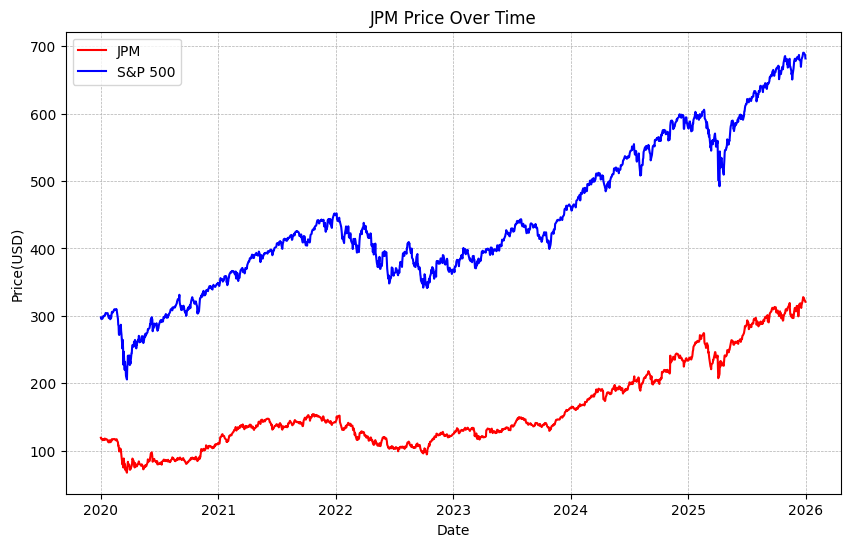

In [6]:
plt.figure(figsize=(10,6))
plt.plot(df['JPM_Price'], color='red', label='JPM')
plt.plot(df['Market_Price'], color='blue', label='S&P 500')
plt.title('JPM Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [7]:
# features list
df['Market_Return']= np.log(df['Market_Price']/df['Market_Price'].shift(1))

df['log_ret'] = np.log(df['JPM_Price']/ df['JPM_Price'].shift(1))
df.dropna(inplace=True)

Augmented Dickey Fuller Test :

Null hypothesis: Series is non-stationary

Alt. hypothesis: Series is not non-stationary


In [10]:
print(" Augmented Dickey Fuller Test")
result= adfuller(df['log_ret'])
print(f" ADF Statistic: {result[0]}")
print(f" p-value: {result[1]}")

if result[1]<0.05:
    print(" Data is Stationary")
else:
    print("WARNING: Data is not Stationary. Model may fail.")

 Augmented Dickey Fuller Test
 ADF Statistic: -11.359101086954666
 p-value: 9.571056575144549e-21
 Data is Stationary


In [11]:
# lag values
df['lag_1']= df['log_ret'].shift(1) # yesterday's return
df['lag_2']= df['log_ret'].shift(2) # 2 days ago

# rolling volatility
df['rolling_vol'] = df['log_ret'].rolling(window=30).std()

# market lag value or beta
df['market_lag_1']= df['Market_Return'].shift(1)

In [12]:
df.dropna(inplace=True)

# splitting data

In [13]:
# keep shuffle = false so that it doesn't shuffle the TS data to ensure the randomness
X= df[['lag_1', 'lag_2', 'rolling_vol', 'market_lag_1']]
y= df['log_ret']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False,)

In [14]:
# the test dates MUST be after the train dates
print(f"Training Range: {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing Range: {X_test.index.min()} to {X_test.index.max()}")

Training Range: 2020-02-14 00:00:00 to 2024-10-24 00:00:00
Testing Range: 2024-10-25 00:00:00 to 2025-12-31 00:00:00


In [15]:
print(f"Training Range: {y_train.index.min()} to {y_train.index.max()}")
print(f"Testing Range: {y_test.index.min()} to {y_test.index.max()}")

Training Range: 2020-02-14 00:00:00 to 2024-10-24 00:00:00
Testing Range: 2024-10-25 00:00:00 to 2025-12-31 00:00:00


In [16]:
print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")

Training Samples: 1182
Testing Samples: 296


# Model A (ARIMA)

In [17]:
# Auto Arima searches for the best (p,q,d) parameters
# seasonal= False as Crypto doesn't have this component

model= pm.auto_arima(y_train,X=X_train,
                     start_p=1, start_q=1,
                     max_p=5, max_q=5,
                     seasonal= True,
                     trace= True, # print progress
                     d= None, # let model figure out differencing
                     error_action= 'ignore',
                     suppress_warnings= True,
                     stepwise= True
                     )
print("Best model found by auto arima")
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5841.943, Time=1.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5845.750, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5843.750, Time=1.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5843.749, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5847.675, Time=0.55 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 3.901 seconds
Best model found by auto arima
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1182
Model:                        SARIMAX   Log Likelihood                2928.837
Date:                Fri, 16 Jan 2026   AIC                          -5847.675
Time:                        23:26:51   BIC                          -5822.300
Sample:                             0   HQIC                         -5838.109
                               - 1182   

In [19]:
# model fitting
model_arimax= ARIMA(y_train, exog= X_train,
                    order=(1,0,1))
arimax_fit=model_arimax.fit()

In [20]:
arimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                log_ret   No. Observations:                 1182
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2928.973
Date:                Fri, 16 Jan 2026   AIC                          -5841.946
Time:                        23:27:00   BIC                          -5801.346
Sample:                             0   HQIC                         -5826.641
                               - 1182                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0006      0.001      0.517      0.605      -0.002       0.003
lag_1           -0.0794      0.142     -0.559      0.576      -0.357       0.199
lag_2            0.1039      0.031      3.402      0.001       0.044       0.164
rolling_vol     -0.0015      0.030     -0.049      0.961      -0.060       0.057
market_lag_1    -0.0818      0.036     -2.293      0.022      -0.152      -0.012
ar.L1         1.122e-08      0.069   1.62e-07      1.000      -0.136       0.136
ma.L1         7.019e-09      0.069   1.01e-07      1.000      -0.136       0.136
sigma2           0.0004   7.96e-06     51.762      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4911.86
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.04e+16. Standard errors may be unstable.
"""

In [21]:
forecast_result= arimax_fit.get_forecast(steps= len(X_test), exog= X_test)
pred_arima= forecast_result.predicted_mean
CI= forecast_result.conf_int(alpha=0.05)

In [22]:
pred_arima= pd.Series(pred_arima.values, index= y_test.index)
lower_bound= pd.Series(CI.iloc[:,0].values, index= y_test.index)
upper_bound= pd.Series(CI.iloc[:,1].values, index= y_test.index)

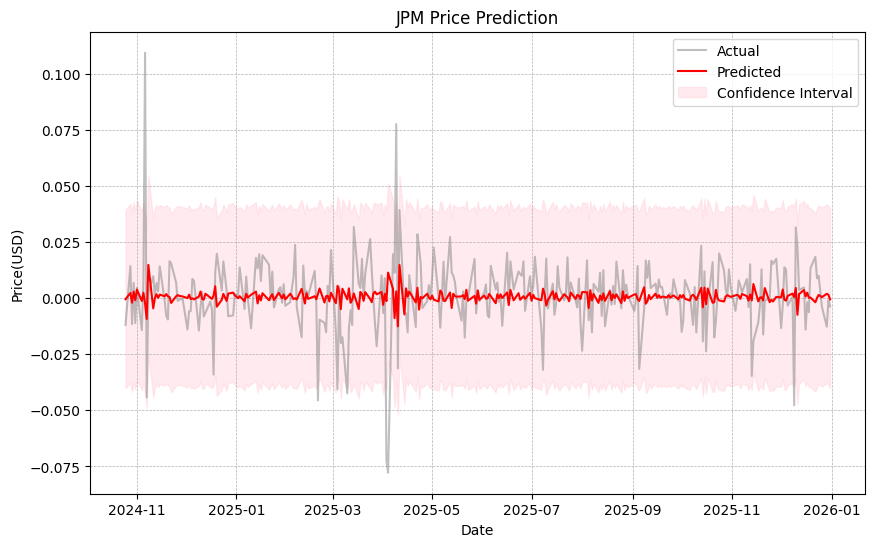

In [23]:
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual', color= 'gray', alpha=0.5)
plt.plot(pred_arima.index, pred_arima, label='Predicted', color='red', linewidth=1.5)
plt.fill_between(pred_arima.index, lower_bound, upper_bound, color='pink', alpha=0.3, label='Confidence Interval')
plt.title('JPM Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

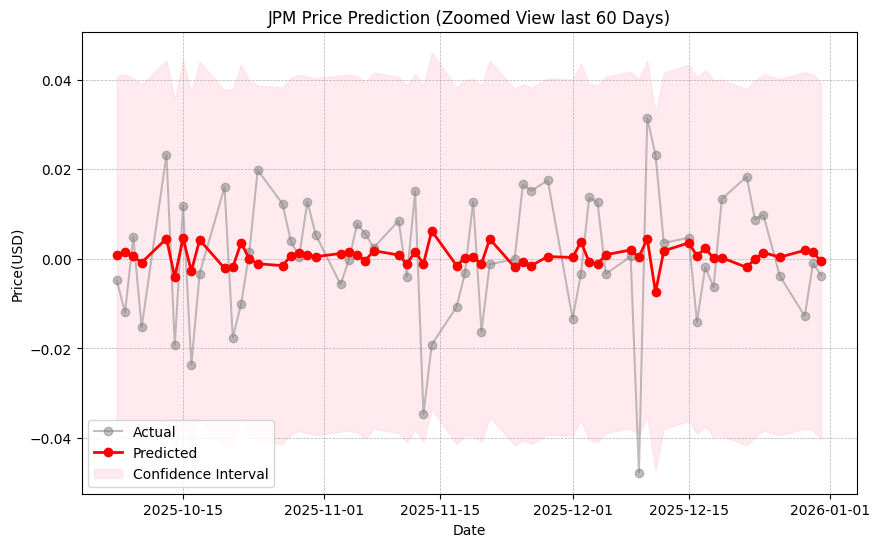

In [24]:
# zoomed into last 60 observations
zoom_days= 60

plt.figure(figsize=(10,6))
plt.plot(y_test.index[-zoom_days:], y_test[-zoom_days:], label='Actual', color= 'gray', alpha=0.5, marker='o')
plt.plot(pred_arima.index[-zoom_days:], pred_arima[-zoom_days:], label='Predicted', color='red', linewidth=2, marker='o')
plt.fill_between(pred_arima.index[-zoom_days:], lower_bound[-zoom_days:], upper_bound[-zoom_days:], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('JPM Price Prediction (Zoomed View last 60 Days)')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Model B (XGBOOST)

In [25]:
model_xgb= xgb.XGBRegressor(n_estimators=10000,
                            max_depth=5, # prevents overfitting noise
                            learning_rate=0.01, random_state=42)
model_xgb.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [26]:
pred_xgb= model_xgb.predict(X_test)
pred_xgb= pd.Series(pred_xgb, index= y_test.index)

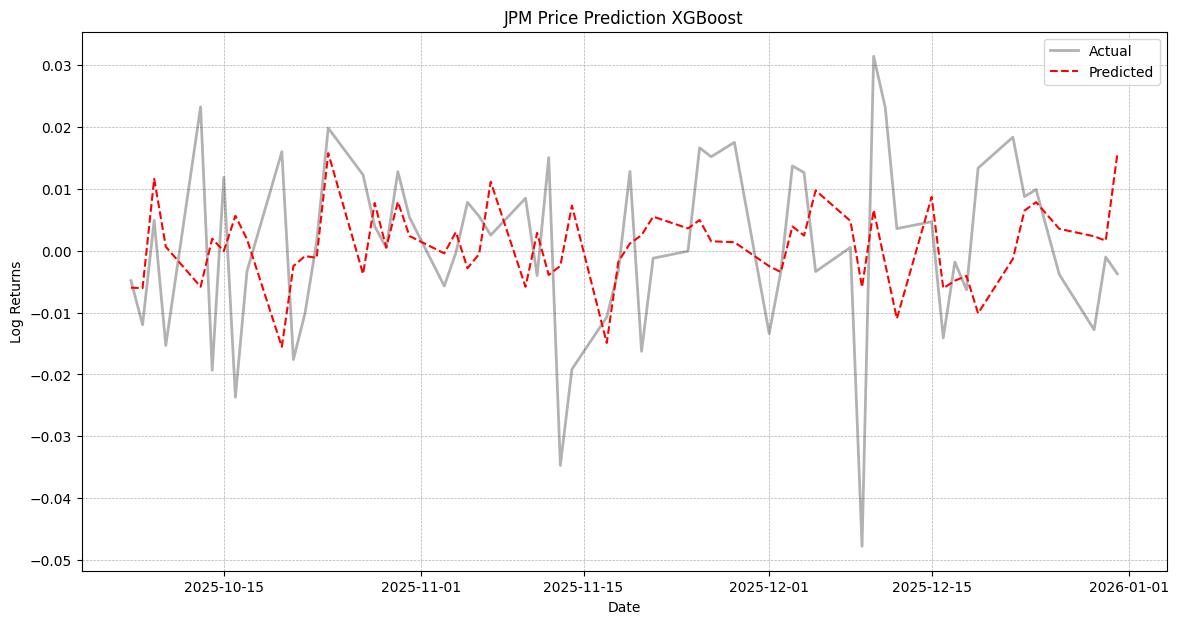

In [27]:
# visulaisation
zoom=60
plt.figure(figsize=(14,7))
plt.plot(y_test.index[-zoom:], y_test[-zoom:], label='Actual', color= 'black', alpha=0.3, linewidth=2)
plt.plot(pred_xgb.index[-zoom:], pred_xgb[-zoom:], label='Predicted', color='red', linewidth=1.5, linestyle='--')
plt.title('JPM Price Prediction XGBoost')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Combined Model

In [28]:
pred_ensemble= (pred_arima + pred_xgb) / 2
pred_ensemble= pd.Series(pred_ensemble.values, index= y_test.index)

In [29]:
# Evaluation
rmse_ensemble= np.sqrt(mean_squared_error(y_test, pred_ensemble))
rmse_xgb= np.sqrt(mean_squared_error(y_test, pred_xgb))
rmse_arima= np.sqrt(mean_squared_error(y_test, pred_arima))

print('Final Root Mean Squared Error(RMSE) Errors:')
print(f"for Model B (XGB): {rmse_xgb}")
print(f"for Model A(ARIMA): {rmse_arima}")
print(f" for ensembled model: {rmse_ensemble}")

Final Root Mean Squared Error(RMSE) Errors:
for Model B (XGB): 0.019076361507760573
for Model A(ARIMA): 0.016559548847494138
 for ensembled model: 0.017087251548322083


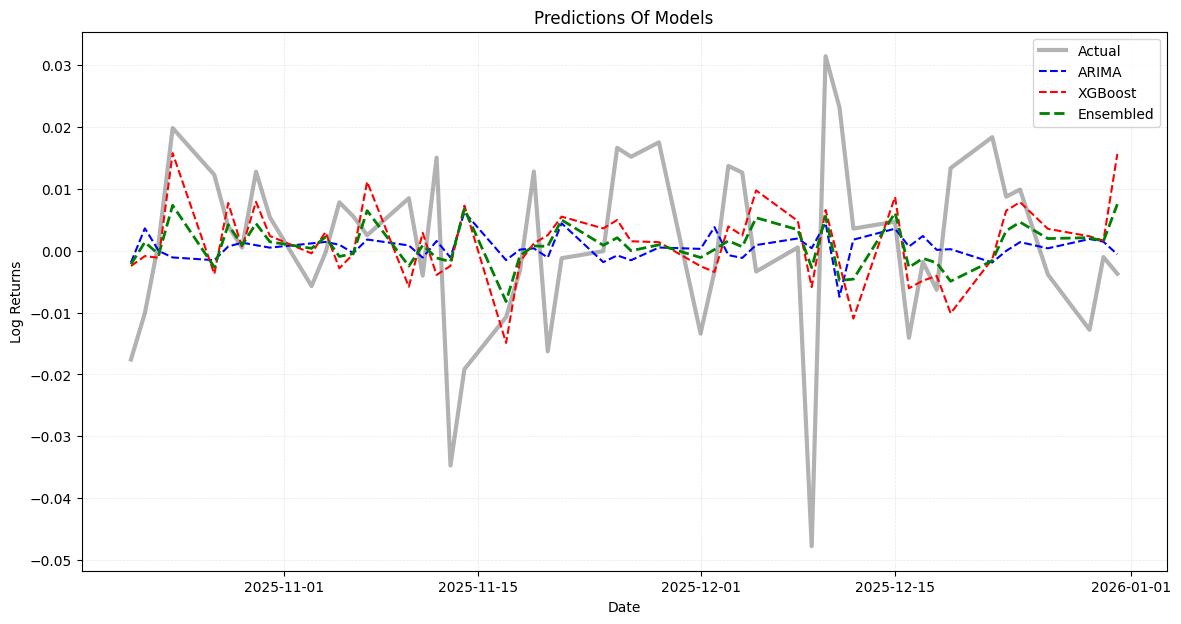

In [30]:
# Combined Visualisation
plt.figure(figsize=(14,7))
zoom= 50
plt.plot(y_test.index[-zoom:], y_test[-zoom:], label='Actual', color= 'black', alpha=0.3, linewidth=3)
plt.plot(pred_arima.index[-zoom:], pred_arima[-zoom:], label='ARIMA', color='blue', linestyle='--')
plt.plot(pred_xgb.index[-zoom:], pred_xgb[-zoom:], label='XGBoost', color='red', linestyle='--')
plt.plot(pred_ensemble.index[-zoom:], pred_ensemble[-zoom:], label='Ensembled', color='green', linestyle='--', linewidth=2)
plt.title('Predictions Of Models')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3, linewidth=0.5)
plt.show()

# Visualisations

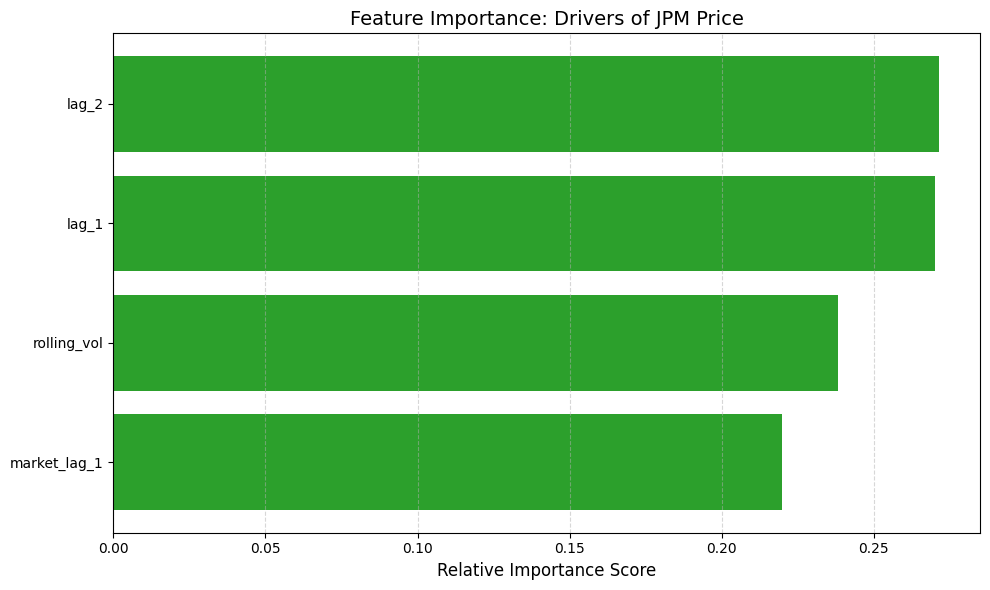

In [35]:
plt.figure(figsize=(10, 6))

# Extract feature importances from XGBoost
importances = model_xgb.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)

# Create a horizontal bar chart
plt.title('Feature Importance: Drivers of JPM Price', fontsize=14)
plt.barh(range(len(indices)), importances[indices], color='#2ca02c', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance Score', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the plot
plt.savefig('feature_importance.png', dpi=300)

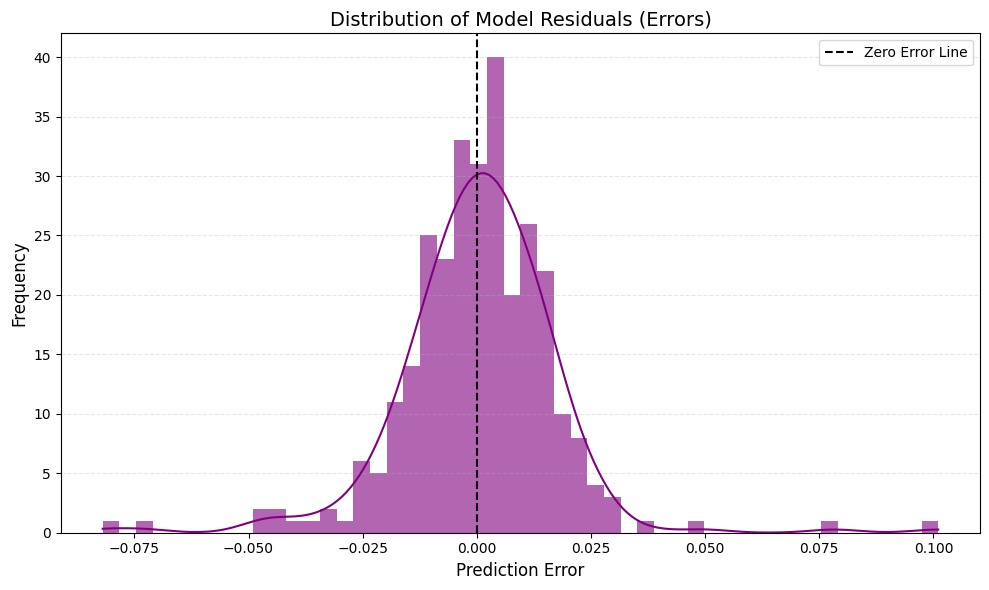

In [33]:
residuals = y_test - pred_ensemble

plt.figure(figsize=(10, 6))

# Plot Histogram with Kernel Density Estimate (KDE) line
# If you don't have seaborn installed, just use plt.hist(residuals, bins=50, density=True)
try:
    sns.histplot(residuals, kde=True, color='purple', bins=50, alpha=0.6, edgecolor=None)
except NameError:
    plt.hist(residuals, bins=50, density=True, color='purple', alpha=0.6)

plt.axvline(0, color='black', linestyle='--', linewidth=1.5, label='Zero Error Line')
plt.title('Distribution of Model Residuals (Errors)', fontsize=14)
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig('residuals_distribution.png', dpi=300)

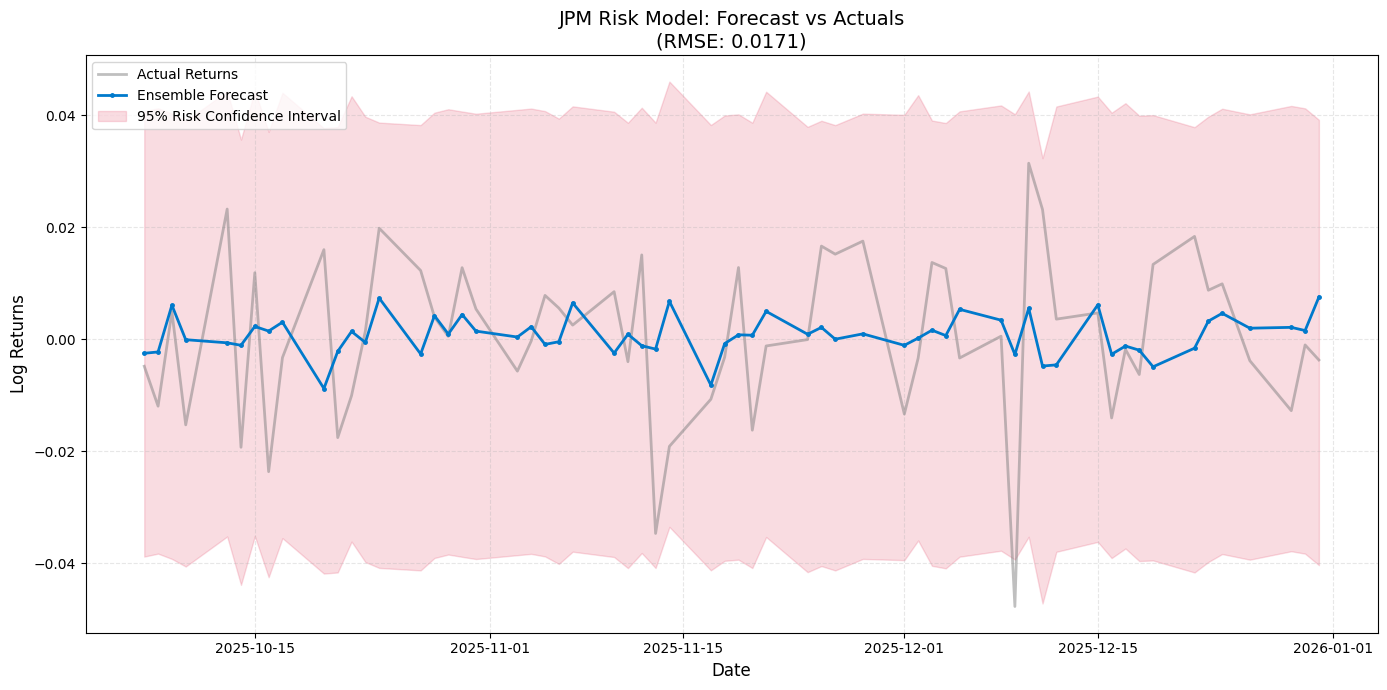

In [34]:
plt.figure(figsize=(14, 7))

# Zoom in on the last 60 days for a clear view
zoom = 60
dates = y_test.index[-zoom:]

# Plot Actuals (Grey)
plt.plot(dates, y_test.values[-zoom:], label='Actual Returns', color='gray', alpha=0.5, linewidth=2)

# Plot Ensemble Prediction (Blue)
plt.plot(dates, pred_ensemble.values[-zoom:], label='Ensemble Forecast', color='#007acc', linewidth=2, marker='.', markersize=5)

# Plot Risk Bounds (Pink Confidence Interval)
# We use the bounds from the ARIMA model (calculated earlier as 'lower' and 'upper')
# Ensure 'lower' and 'upper' are aligned with the zoomed dates
lower_zoom = CI.iloc[-zoom:, 0] # Changed conf_int to CI
upper_zoom = CI.iloc[-zoom:, 1] # Changed conf_int to CI

plt.fill_between(dates, lower_zoom, upper_zoom, color='crimson', alpha=0.15, label='95% Risk Confidence Interval')

plt.title(f'JPM Risk Model: Forecast vs Actuals\n(RMSE: {rmse_ensemble:.4f})', fontsize=14) # Changed rmse_ens to rmse_ensemble and removed market_std
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Returns', fontsize=12)
plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig('forecast_with_risk_bounds.png', dpi=300)